In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

# from IPython.display import clear_output
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader

# torch.manual_seed(20210614)

import time


***Here we employ grid search, random and bayezian methods for finding the hyperparameters for the optimized NN structure.***

We employ the following stages:

- Reading the original data and separating the outputs 
- making train-test splits

In [9]:
""" Exp1, 2"""

address = '/Volumes/GoogleDrive-117271245802891063093/My Drive/PostDoc/MLFE/ML-NRC-paper1/Data/'

df_0 = pd.read_csv(address + 'Param0_2width.csv')
df_1 = pd.read_csv(address +'Param1_2width.csv')
df_2 = pd.read_csv(address +'Param2_2width.csv')
df_3 = pd.read_csv(address +'Param3_2width.csv')
df_4 = pd.read_csv(address +'Param4_2width.csv')

combined_Exp = pd.concat([df_0, df_1, df_2, df_3, df_4], axis = 0, ignore_index = True)
combined_Exp = shuffle(combined_Exp, random_state=20210614)

###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

df = pd.DataFrame(df_norm, columns=combined_Exp.columns )


X = df.drop(['Depth', 'Top_width', 'Bot_width', 'Speed'], axis = 'columns')
Dpt = df.Depth.values
Top_w = df.Top_width.values
Bot_w = df.Bot_width.values

##-------- split the data to training (80%) and test (20%) data sets
Xtrain, Xtest, Dpt_train, Dpt_test, Topw_train, \
                Topw_test, Botw_train, Botw_test = train_test_split(X, Dpt, Top_w, Bot_w,\
                                                test_size = 0.1, random_state = 20210614)

In [10]:
# ##-------- If you want to predict Depth
Y_train = np.c_[Dpt_train]
Y_test = np.c_[Dpt_test]

# # ##-------- If you want to predict top_width
# Y_train = np.c_[Topw_train]
# Y_test = np.c_[Topw_test]

# # ##--------If you want to predict Bot_width
# Y_train = np.c_[Botw_train]
# Y_test = np.c_[Botw_test]

In [11]:
class Fare_Predictor(nn.Module):
    def __init__(self, input_dim=4, no_layers=3, drp=0.2, output=1):
        super().__init__()
        if no_layers == 3:
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(64, 32), 
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(32, output) 
            )
        elif no_layers == 2:
            self.net = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(drp),
                nn.Linear(32, output) 
            )
        
    def forward(self, input):
        return self.net(input)

In [12]:
def training(x_train=Xtrain, y_train=Y_train, x_test=Xtest, y_test=Y_test,\
             lr=0.001, l2=0.0001, batch_size=64, epochs=3000):
    
    torch.manual_seed(20210614)
    losses=[]
    
    x_train, y_train, x_test, y_test = map(
    torch.FloatTensor, (x_train.values, y_train, x_test.values, y_test)
    )
#     y_train = y_train.reshape(-1,1)
#     y_test = y_test.reshape(-1,1)
    
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size)
    
    model = Fare_Predictor()
    
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=l2)
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
#         if epoch == 0 or epoch % 2 == 0:
#             print(loss)
        losses.append(loss)
    plt.plot(losses)
    model.eval()
    pred = model(x_test)
    y = y_test
    mse = mean_squared_error(pred.detach().numpy(), y.detach().numpy())
    print('MSE on test set: {}'.format(mse))
#     return pred.detach().numpy()
    return -mse
        

When the lr=0.001, l2= 0.0001, batch_size=64 and epochs=3000 are used for NN:
MSE on test set: 0.005951165221631527


-0.005951165

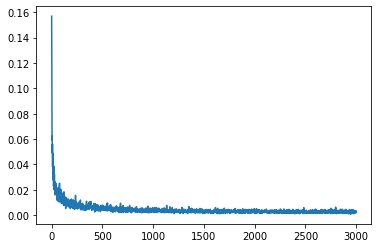

In [13]:
print('When the lr=0.001, l2= 0.0001, batch_size=64 and epochs=3000 are used for NN:')
training()

## Grid Search:
we can specify ranges for some parameters to grid search over and find the parameters corresponding to the smallest mse on training set

In [22]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

def gs_tune(x_train, y_train):
    x_train , y_train = np.array(x_train), np.array(y_train)
    x_train = x_train.astype(np.float32)
    y_train = y_train.astype(np.float32)

    net = NeuralNetRegressor(Fare_Predictor,
                             optimizer = torch.optim.Adam
                             , verbose = 0
#                              , max_epochs = 3000
#                              , lr = 0.001
                             , batch_size = 64
#                              , optimizer__weight_decay = .0001
                            )
    
    param_grid = {   # arange([start,] stop[, step,], dtype=None)
       'lr' : np.arange(1e-4, 1e-2, 0.005),
#         'batch_size' : [16, 64],
        'max_epochs' : np.arange(500, 2000, 1000), 
        'optimizer__weight_decay' : np.arange(1e-4, 1e-2, 0.005) 
    }
    
#     y_train = y_train.reshape(-1,1)
    gs = GridSearchCV(net, param_grid, refit=True, cv = 2, scoring='neg_mean_squared_error')
    gs.fit(x_train, y_train)
    return gs

start = time.time()
grid_model = gs_tune(Xtrain, Y_train)
end = time.time()

print('Grid search takes {:.2f} seconds to tune'.format(end-start))
x_test = np.array(Xtest)
x_test = x_test.astype(np.float32)
out = grid_model.predict(x_test)
MSE = mean_squared_error(out, Y_test)
print('MSE on test set is :{}'.format(MSE))
    

Grid search takes 132.73 seconds to tune
MSE on test set is :0.006689188546189147


In [23]:
print(grid_model.best_params_)

{'lr': 0.0051, 'max_epochs': 1500, 'optimizer__weight_decay': 0.0001}


MSE on test set: 0.010715842247009277


-0.010715842

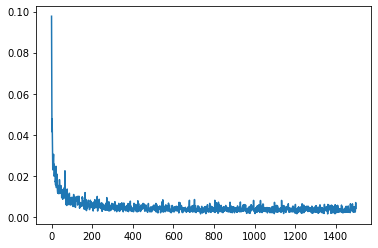

In [25]:
training(x_train=Xtrain, y_train=Y_train, x_test=Xtest, y_test=Y_test,\
         lr=grid_model.best_params_.get('lr'),\
         l2=grid_model.best_params_.get('optimizer__weight_decay'),\
         batch_size=64,\
         epochs=grid_model.best_params_.get('max_epochs')
        )

## Random Search
In random search values are taken n_iter times randomly from the specified ranges and their MSE are compared and the best parameters with n_iteration search are reported.   

In [33]:
from sklearn.model_selection import RandomizedSearchCV

def rs_tune(x_train, y_train):
    x_train , y_train = np.array(x_train), np.array(y_train)
    x_train = x_train.astype(np.float32)
    y_train = y_train.astype(np.float32)

    net = NeuralNetRegressor(Fare_Predictor,
                             optimizer = torch.optim.Adam
                             , verbose = 0
#                              , max_epochs = 3000
#                              , lr = 0.001
                             , batch_size = 64
#                              , optimizer__weight_decay = .001
                            )
    
    param_grid = {
       'lr' : np.arange(1e-4, 1e-2, 0.001),
#         'batch_size' : np.arange(16, 129, 16),
        'max_epochs' : np.arange(500, 1000, 100), 
        'optimizer__weight_decay' : np.arange(1e-4, 1e-2, .001) 
    }
    
#     y_train = y_train.reshape(-1,1)
    rs = RandomizedSearchCV(net, param_grid, refit=True, n_iter=20, cv=3, scoring='neg_mean_squared_error')
    rs.fit(x_train, y_train)
    return rs

start = time.time()
grid_model = rs_tune(Xtrain, Y_train)
end = time.time()
print('Random search takes {:.2f} seconds to tune'.format(end-start))
                             
x_test = np.array(Xtest)
x_test = x_test.astype(np.float32)
                             
out = grid_model.predict(x_test)
MSE = mean_squared_error(out, Y_test)
print('MSE on test set is :{}'.format(MSE))

Random search takes 255.24 seconds to tune
MSE on test set is :0.005029939368476528


In [34]:
print(grid_model.best_params_)

{'optimizer__weight_decay': 0.0001, 'max_epochs': 500, 'lr': 0.0041}


MSE on test set: 0.005382168106734753


-0.005382168

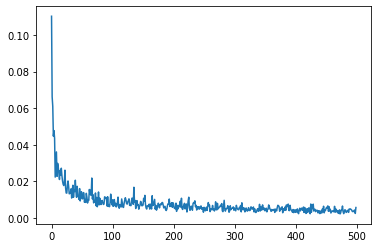

In [35]:
training(x_train=Xtrain, y_train=Y_train, x_test=Xtest, y_test=Y_test,\
         lr=grid_model.best_params_.get('lr'),\
         l2=grid_model.best_params_.get('optimizer__weight_decay'),\
         batch_size=64,\
         epochs=grid_model.best_params_.get('max_epochs')
        )

## Bayesian optimization
Bayesian Optimization also runs models many times with different sets of hyperparameter values, but it evaluates the past model information to select hyperparameter values to build the newer model. This is said to spend less time to reach the highest accuracy model

MSE on test set: 0.014935449697077274
MSE on test set: 0.004807372577488422
MSE on test set: 0.006988943554461002
MSE on test set: 0.008183571510016918
MSE on test set: 0.01310526393353939
MSE on test set: 0.01337637472897768
MSE on test set: 0.010165884159505367
MSE on test set: 0.006986874155700207
MSE on test set: 0.01564430631697178
MSE on test set: 0.006185063160955906
MSE on test set: 0.0052506509236991405
MSE on test set: 0.006728638429194689
MSE on test set: 0.004922544118016958
MSE on test set: 0.0062604304403066635
MSE on test set: 0.014801952987909317
MSE on test set: 0.004672167357057333
MSE on test set: 0.005713275633752346
MSE on test set: 0.0053055500611662865
MSE on test set: 0.006134477909654379
MSE on test set: 0.0057866452261805534
MSE on test set: 0.007955830544233322
MSE on test set: 0.00549683440476656
MSE on test set: 0.00518688652664423
MSE on test set: 0.0046609933488070965
MSE on test set: 0.005016937851905823
MSE on test set: 0.004959973506629467
MSE on test 

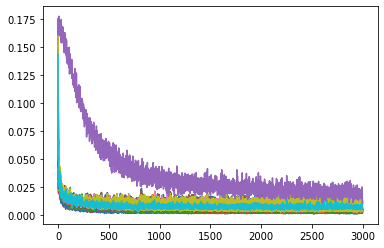

In [36]:
from bayes_opt import BayesianOptimization

pbounds = {
    'lr' : (1e-5, 1e-2),
    'l2' : (1e-5, 1e-2), 
    'max_epochs' : (500, 1000)
}

optimizer = BayesianOptimization(
    f = training, 
    pbounds = pbounds,
    verbose = 0,
    random_state = 1,
)

start = time.time()

optimizer.maximize(
    init_points = 10,
    n_iter = 20,
)

end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end-start))

print(optimizer.max)


In [ ]:
# for i, res in enumerate(optimizer.res):
#     print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
# ! pip install bayesian-optimization

In [ ]:
training(Xtrain, Y_train, Xtest, Y_test,lr=0.01  , l2= 1e-05, batch_size=64, epochs = 800)